# Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the data 

In [10]:
def analyze_target_file(target_csv):
    """
    Analyze target.csv to get counts of samples
    """
    # Read target file
    targets = pd.read_csv(target_csv)
    
    # Calculate total samples
    total_samples = len(targets)
    
    # Calculate samples per label
    label_counts = targets['labels'].value_counts()
    
    print(f"Total number of samples: {total_samples}")
    print("\nSamples per label:")
    for label, count in label_counts.items():
        print(f"{label}: {count}")
        
    # Print counts for binary classifications
    print("\nBinary classification counts:")
    
    # Face vs House
    face_house = targets[targets['labels'].isin(['face', 'house'])]
    face_count = len(face_house[face_house['labels'] == 'face'])
    house_count = len(face_house[face_house['labels'] == 'house'])
    print(f"\nFace vs House:")
    print(f"Face: {face_count}")
    print(f"House: {house_count}")
    print(f"Total: {face_count + house_count}")
    
    # Face vs Scissors
    face_scissors = targets[targets['labels'].isin(['face', 'scissors'])]
    face_count = len(face_scissors[face_scissors['labels'] == 'face'])
    scissors_count = len(face_scissors[face_scissors['labels'] == 'scissors'])
    print(f"\nFace vs Scissors:")
    print(f"Face: {face_count}")
    print(f"Scissors: {scissors_count}")
    print(f"Total: {face_count + scissors_count}")

if __name__ == "__main__":
    TARGET_CSV = "targets.csv"
    analyze_target_file(TARGET_CSV)

Total number of samples: 1452

Samples per label:
rest: 588
scissors: 108
face: 108
cat: 108
shoe: 108
house: 108
scrambledpix: 108
bottle: 108
chair: 108

Binary classification counts:

Face vs House:
Face: 108
House: 108
Total: 216

Face vs Scissors:
Face: 108
Scissors: 108
Total: 216


## Preprocessing the data for binary classification


In [15]:
def create_binary_dataset(base_folder, region, target_csv, label1, label2):
    """
    Create binary classification dataset for one region
    """
    print(f"\nProcessing {label1} vs {label2} for region {region}")
    
    # Read feature file (space-separated, no header)

    print(region)

    if region == "vt":

        feature_file = os.path.join(base_folder, region, "features.csv")
        features = pd.read_csv(feature_file, header=None, sep=' ')
    else:
        region_full = os.path.join(region, "RL")
        feature_file = os.path.join(base_folder, region_full, "features.csv")
        print(feature_file)
        features = pd.read_csv(feature_file, header=None, sep=' ')

    
    # Read target labels
    targets = pd.read_csv(target_csv)
    
    # Filter for required labels
    mask = targets['labels'].isin([label1, label2])
    filtered_targets = targets[mask]
    
    # Get features for selected labels using row indices
    selected_features = features.iloc[filtered_targets.index - 1]
    
    # Create binary labels (0 for label1, 1 for label2)
    binary_labels = (filtered_targets['labels'] == label2).astype(int)
    
    # Create final dataframe
    final_df = selected_features.copy()
    final_df['label'] = binary_labels.values
    final_df['label_name'] = filtered_targets['labels'].values
    
    # Save to CSV without index and without numbering the feature columns

    output_file = f"{region}_{label1}_vs_{label2}.csv"
    final_df.to_csv(output_file, index=False, header=False)
    print(f"Created {output_file}")
    print(f"Number of {label1}: {sum(binary_labels == 0)}")
    print(f"Number of {label2}: {sum(binary_labels == 1)}")

def main():
    # Settings
    BASE_FOLDER = "subj1"  # Change this to your base folder path
    REGIONS = ["vt", "Inferior_frontal"]
    TARGET_CSV = "targets.csv"
    
    # Process each region
    for region in REGIONS:
        # Create face vs house dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "house")
        
        # Create face vs scissors dataset
        create_binary_dataset(BASE_FOLDER, region, TARGET_CSV, "face", "scissors")

if __name__ == "__main__":
    main()


Processing face vs house for region vt
vt
Created vt_face_vs_house.csv
Number of face: 108
Number of house: 108

Processing face vs scissors for region vt
vt


Created vt_face_vs_scissors.csv
Number of face: 108
Number of scissors: 108

Processing face vs house for region Inferior_frontal
Inferior_frontal
subj1/Inferior_frontal/RL/features.csv
Created Inferior_frontal_face_vs_house.csv
Number of face: 108
Number of house: 108

Processing face vs scissors for region Inferior_frontal
Inferior_frontal
subj1/Inferior_frontal/RL/features.csv
Created Inferior_frontal_face_vs_scissors.csv
Number of face: 108
Number of scissors: 108


In [10]:
def load_and_preprocess(file_path, mode = "all_features"):
    """Load and preprocess the data"""
    # Read CSV
    data = pd.read_csv(file_path, header=None)




    
    # Last two columns are label and label_name
    X = data.iloc[:, :-2].values
    y = data.iloc[:, -2].values  # Binary label (0 or 1)
    label_names = data.iloc[:, -1].values  # Label names


    if mode != "all_features":
        np.random.seed(42)


                # Separate samples by class
        class_0_indices = np.where(y == 0)[0]
        class_1_indices = np.where(y == 1)[0]
        
        # Select 50% from each class 
        n_samples_per_class = len(class_0_indices) // 2
        selected_class_0 = np.random.choice(class_0_indices, size=n_samples_per_class, replace=False)
        selected_class_1 = np.random.choice(class_1_indices, size=n_samples_per_class, replace=False)
        
        # Combine selected indices
        selected_indices = np.concatenate([selected_class_0, selected_class_1])
        
        # Get selected samples
        X = X[selected_indices]
        y = y[selected_indices]
        label_names = label_names[selected_indices]

        print(f"Total samples: {len(y)} (50% of original)")

        


    
    # Print dataset information

    groups = np.arange(len(y))
    unique_labels, counts = np.unique(label_names, return_counts=True)
    print("\nDataset Information:")
    print(f"Total samples: {len(y)}")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, groups

def train_and_evaluate_models(X, y, groups, contrast_name):
    """Train and evaluate multiple models using LeaveOneGroupOut"""
    print(f"\n{contrast_name} Information:")
    print(f"Total samples: {len(y)} ({np.sum(y == 0)} class 0, {np.sum(y == 1)} class 1)")
    
    # Define models
    models = {
        'RF': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
        'SVM': SVC(kernel='rbf', C=1.0, random_state=42)
    }
    
    # Initialize cross-validation
    logo = LeaveOneGroupOut()
    
    # Results storage
    results = {}
    cv_scores = {}
    
    for name, model in models.items():
        print(f"\nTraining {name} for {contrast_name}...")
        
        # Perform LeaveOneGroupOut cross-validation
        scores = []
        for train_idx, test_idx in logo.split(X, y, groups):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Train and predict
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Store score
            scores.append(accuracy_score(y_test, y_pred))
        
        # Store results
        cv_scores[name] = np.array(scores)
        results[name] = np.mean(scores)
        
        print(f"Mean CV accuracy: {results[name]:.3f} (+/- {np.std(scores)*2:.3f})")
    
    return results, cv_scores

def plot_results(vt_face_house_cv, vt_face_scissors_cv):
    """Create plots for the results"""
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Boxplot data
    data_to_plot = [
        vt_face_house_cv['RF'], vt_face_house_cv['SVM'],
        vt_face_scissors_cv['RF'], vt_face_scissors_cv['SVM']
    ]
    labels = ['RF\nFace vs House', 'SVM\nFace vs House', 
              'RF\nFace vs Scissors', 'SVM\nFace vs Scissors']
    
    # Create boxplot
    print(data_to_plot)
    ax1.boxplot(data_to_plot, labels=labels)
    ax1.set_title('Classification Accuracy Distribution\n(LeaveOneGroupOut CV)')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Bar plot data
    models = ['Random Forest', 'SVM']
    face_house_means = [np.mean(vt_face_house_cv['RF']), np.mean(vt_face_house_cv['SVM'])]
    face_scissors_means = [np.mean(vt_face_scissors_cv['RF']), np.mean(vt_face_scissors_cv['SVM'])]
    
    # Create bar plot
    x = np.arange(len(models))
    width = 0.35
    
    ax2.bar(x - width/2, face_house_means, width, label='Face vs House')
    ax2.bar(x + width/2, face_scissors_means, width, label='Face vs Scissors')
    
    ax2.set_ylabel('Mean Accuracy')
    ax2.set_title('Mean Classification Accuracy by Model\n(LeaveOneGroupOut CV)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



In [11]:
def run(data1, data2, mode = "all_features"):
    print("=== VT Region Classification Analysis ===")
    
    # Load and process data
    print(f"\nProcessing {data1}")
    X_face_house, y_face_house, groups_face_house = load_and_preprocess(data1, mode)
    
    print(f"\nProcessing {data2}")
    X_face_scissors, y_face_scissors, groups_face_scissors = load_and_preprocess(data2, mode)
    
    # Train and evaluate models
    results_face_house, cv_scores_face_house  = train_and_evaluate_models(
        X_face_house, y_face_house,groups_face_house, "Face vs House")
    
    results_face_scissors, cv_scores_face_scissors  = train_and_evaluate_models(
        X_face_scissors, y_face_scissors,groups_face_scissors ,"Face vs Scissors")
    
    # Summary of results
    print("\n=== Summary of Results ===")
    print("\nFace vs House:")
    for name, acc in results_face_house.items():
        cv_mean = np.mean(cv_scores_face_house[name])
        cv_std = np.std(cv_scores_face_house[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    print("\nFace vs Scissors:")
    for name, acc in results_face_scissors.items():
        cv_mean = np.mean(cv_scores_face_scissors[name])
        cv_std = np.std(cv_scores_face_scissors[name])
        print(f"{name}: Test Acc = {acc:.3f}, CV Acc = {cv_mean:.3f} (+/- {cv_std*2:.3f})")
    
    # Create plots
    plot_results(cv_scores_face_house, cv_scores_face_scissors)



# Binary Classification of VT region (all fetures) (face vs house) and (face vs scissors)


=== VT Region Classification Analysis ===

Processing vt_face_vs_house.csv

Dataset Information:
Total samples: 216
face: 108 samples
house: 108 samples

Processing vt_face_vs_scissors.csv

Dataset Information:
Total samples: 216
face: 108 samples
scissors: 108 samples

Face vs House Information:
Total samples: 216 (108 class 0, 108 class 1)

Training RF for Face vs House...
Mean CV accuracy: 0.889 (+/- 0.629)

Training SVM for Face vs House...
Mean CV accuracy: 0.935 (+/- 0.492)

Face vs Scissors Information:
Total samples: 216 (108 class 0, 108 class 1)

Training RF for Face vs Scissors...
Mean CV accuracy: 0.875 (+/- 0.661)

Training SVM for Face vs Scissors...
Mean CV accuracy: 0.963 (+/- 0.378)

=== Summary of Results ===

Face vs House:
RF: Test Acc = 0.889, CV Acc = 0.889 (+/- 0.629)
SVM: Test Acc = 0.935, CV Acc = 0.935 (+/- 0.492)

Face vs Scissors:
RF: Test Acc = 0.875, CV Acc = 0.875 (+/- 0.661)
SVM: Test Acc = 0.963, CV Acc = 0.963 (+/- 0.378)
[array([1., 1., 1., 1., 1., 1.

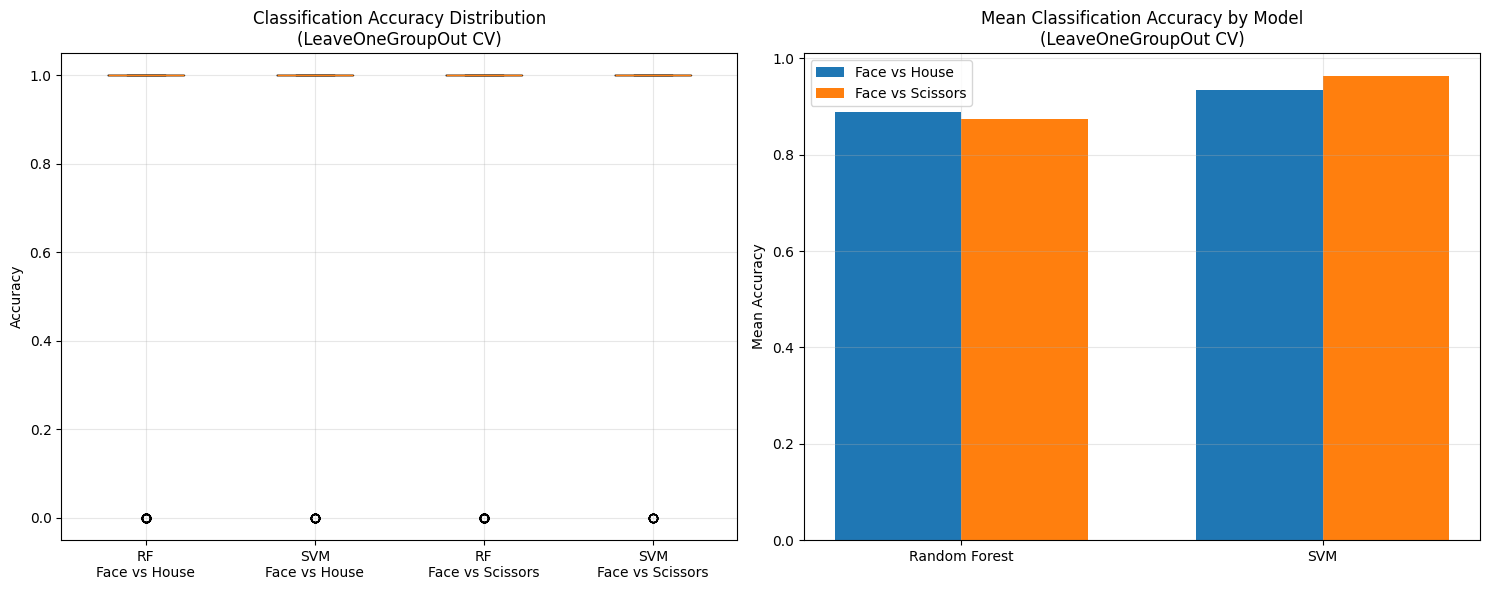

In [12]:
vt_face_house = "vt_face_vs_house.csv"
vt_face_scissors = "vt_face_vs_scissors.csv"
run(vt_face_house, vt_face_scissors)

# Binary Classification of Inferior_frontal region (face vs house) and (face vs scissors)

=== VT Region Classification Analysis ===

Processing Inferior_frontal_face_vs_house.csv

Dataset Information:
Total samples: 216
face: 108 samples
house: 108 samples

Processing Inferior_frontal_face_vs_scissors.csv

Dataset Information:
Total samples: 216
face: 108 samples
scissors: 108 samples

Face vs House Information:
Total samples: 216 (108 class 0, 108 class 1)

Training RF for Face vs House...
Mean CV accuracy: 0.940 (+/- 0.476)

Training SVM for Face vs House...
Mean CV accuracy: 0.940 (+/- 0.476)

Face vs Scissors Information:
Total samples: 216 (108 class 0, 108 class 1)

Training RF for Face vs Scissors...
Mean CV accuracy: 0.921 (+/- 0.539)

Training SVM for Face vs Scissors...
Mean CV accuracy: 0.912 (+/- 0.566)

=== Summary of Results ===

Face vs House:
RF: Test Acc = 0.940, CV Acc = 0.940 (+/- 0.476)
SVM: Test Acc = 0.940, CV Acc = 0.940 (+/- 0.476)

Face vs Scissors:
RF: Test Acc = 0.921, CV Acc = 0.921 (+/- 0.539)
SVM: Test Acc = 0.912, CV Acc = 0.912 (+/- 0.566)


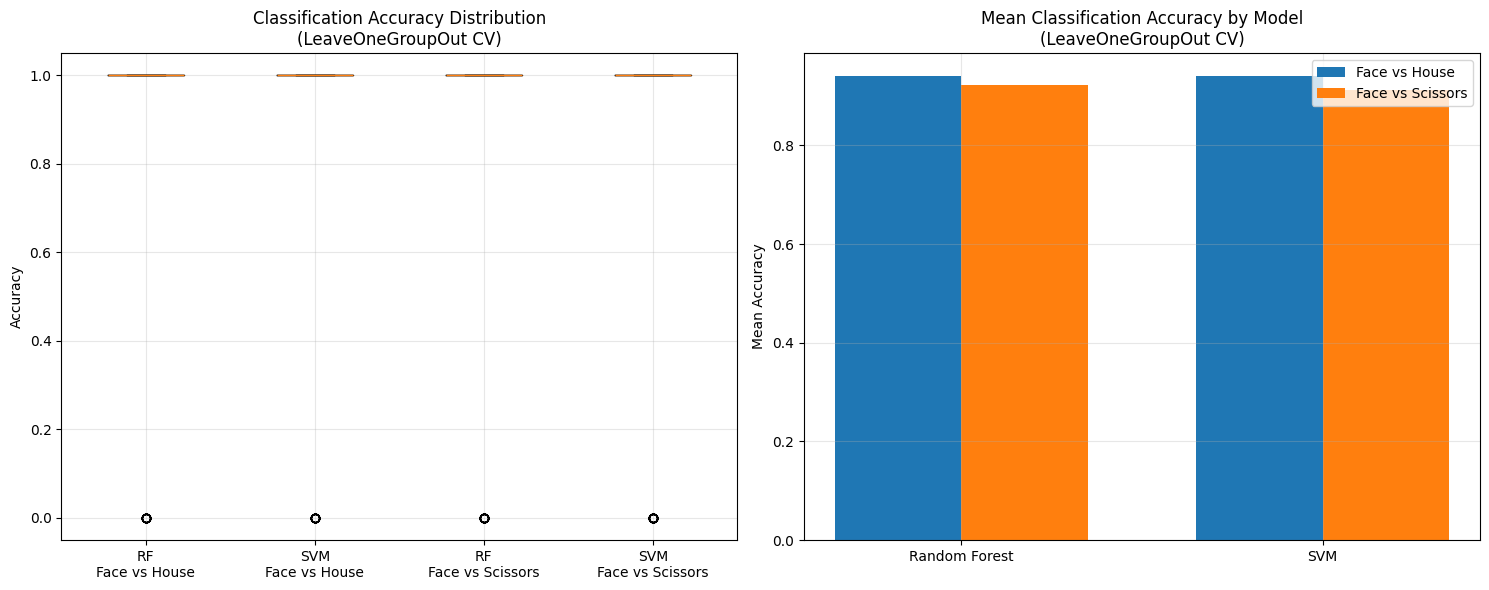

In [9]:
inferior_face_house = "Inferior_frontal_face_vs_house.csv"
inferior_face_scissors = "Inferior_frontal_face_vs_scissors.csv"

run(inferior_face_house, inferior_face_scissors)

# Binary Classification of VT region (50% fetures) (face vs house) and (face vs scissors)

=== VT Region Classification Analysis ===

Processing vt_face_vs_house.csv
Total samples: 108 (50% of original)

Dataset Information:
Total samples: 108
face: 54 samples
house: 54 samples

Processing vt_face_vs_scissors.csv
Total samples: 108 (50% of original)

Dataset Information:
Total samples: 108
face: 54 samples
scissors: 54 samples

Face vs House Information:
Total samples: 108 (54 class 0, 54 class 1)

Training RF for Face vs House...


Mean CV accuracy: 0.843 (+/- 0.728)

Training SVM for Face vs House...
Mean CV accuracy: 0.898 (+/- 0.605)

Face vs Scissors Information:
Total samples: 108 (54 class 0, 54 class 1)

Training RF for Face vs Scissors...
Mean CV accuracy: 0.806 (+/- 0.792)

Training SVM for Face vs Scissors...
Mean CV accuracy: 0.889 (+/- 0.629)

=== Summary of Results ===

Face vs House:
RF: Test Acc = 0.843, CV Acc = 0.843 (+/- 0.728)
SVM: Test Acc = 0.898, CV Acc = 0.898 (+/- 0.605)

Face vs Scissors:
RF: Test Acc = 0.806, CV Acc = 0.806 (+/- 0.792)
SVM: Test Acc = 0.889, CV Acc = 0.889 (+/- 0.629)
[array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1.,

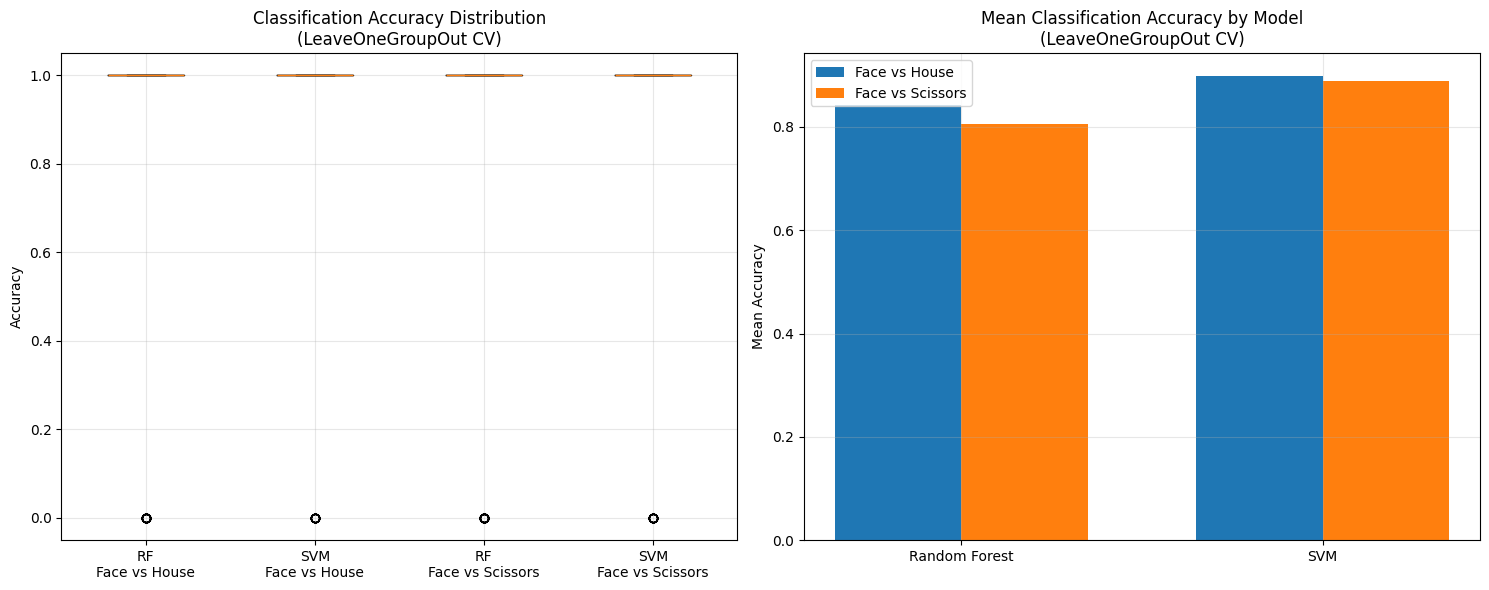

In [13]:
vt_face_house = "vt_face_vs_house.csv"
vt_face_scissors = "vt_face_vs_scissors.csv"
mode = "50_%_features"
run(vt_face_house, vt_face_scissors, mode)